In [1]:
cd '/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting'

/Users/jbud/Desktop/Galvanize/repos/Covid-19-Forecasting


In [2]:
# %load src/reg_model_class.py
import numpy as np
import pandas as pd

import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# from scipy.interpolate import make_interp_spline
# from src.data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround

from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import matplotlib

from matplotlib.dates import (DAILY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)


class reg_model(object):
    def __init__(self, X, y, log_trans_y=False, day_cutoff=93):
        '''
        Day cutoff is split between training and testing data.
        '''
        self.X = X
        if log_trans_y == True:
            elim_invalid = y.copy()
            elim_invalid[elim_invalid < 0] = 0
            self.y = np.log(elim_invalid + 1)
        else:
            self.y = y
        train_mask = self.X['days_elapsed(t)'] < day_cutoff
        holdout_mask = self.X['days_elapsed(t)'] >= day_cutoff
        self.log_trans_y = log_trans_y
        self.X_train, self.X_test, self.y_train, self.y_test = self.X[
            train_mask], self.X[holdout_mask], self.y[train_mask], self.y[holdout_mask]
        self.error_metric = None

    def lin_reg(self):
        self.model = LinearRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def log_reg(self):
        self.model = LogisticRegression()
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def ridge_reg(self, alpha=0.5):
        def optimize_alpha(alpha_list):
            pass
        self.model = Ridge(alpha=alpha)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rss'

    def rand_forest(self, n_trees=100):
        '''
        Upon inspection of the model over time, the number of new cases shows a period of exponential growth, then linear growth where the new cases levels off. Then a random forest model can be applied. 
        '''
        if n_trees == 'optimize':
            '''
            If set to optimize, will take a selection of 1 to max_trees and uses number that minimizes error in training set.
            This can be plotted by uncommenting out the plt.plot(n, error) line.
            '''
            max_trees = 100
            n = np.arange(1, max_trees + 1, 1)
            error = []
            for each in n:
                self.model = RandomForestRegressor(
                    n_estimators=each, n_jobs=-1, random_state=1)
                self.model.fit(self.X_train, self.y_train)
                self.error_metric = 'rmse'
                error.append(self.evaluate_model())
            #plt.plot(n, error)
            n_trees = n[error.index(min(error))]
        # n_jobs = -1, random_state = 0, max_depth = 3, oob_score = False, random_state = 10
        self.model = RandomForestRegressor(
            n_estimators=n_trees, random_state=None)
        self.model.fit(self.X_train, self.y_train)
        self.error_metric = 'rmse'

    def evaluate_model(self, print_err_metric=False):
        self.y_hat = self.model.predict(self.X_test)
        self.predicted_vals_df = pd.DataFrame(self.y_test)
        self.predicted_vals_df['days_elapsed(t)'] = self.X_test['days_elapsed(t)']
        self.predicted_vals_df['y_hat'] = self.y_hat
        self.predicted_vals_df.sort_index(inplace=True)
        if self.error_metric == 'rmse':
            rmse = np.sqrt(mean_squared_error(self.y_test, self.y_hat))
            if print_err_metric:
                print('rmse:', rmse)
            return rmse
        elif self.error_metric == 'rss':
            rss = np.mean((self.y_test - self.y_hat)**2)
            if print_err_metric:
                print('rss: ', rss)
            return rss

    def forecast_vals(self, to_forecast_df):
        self.forecasted = self.model.predict(to_forecast_df)
        return self.forecasted

    def plot_model(self, use_smoothed=True, threshold=100, save_name=None, xvar='days_elapsed(t)', convDate=True):
        '''
        Use smoothed generates data using moving average. 
        Convdate converts days elapsed into date
        '''
        register_matplotlib_converters()
        fig, ax = plt.subplots(figsize=(10, 6))
        if self.log_trans_y == True:
            self.y_test = np.e ** self.y_test
        ax.bar(self.X_test.loc[:, xvar].apply(convert_to_date),
               self.y_test, color='blue', label="Test Data")
        ax.bar(self.X_train.loc[:, xvar].apply(convert_to_date),
               self.y_train, color='red', label="Training Data")
        if use_smoothed == True:
            x, y = create_spline(self.X[xvar], self.y, day_delay=0)
            x = pd.DataFrame(x).iloc[:, 0].apply(convert_to_date)
            ax.plot_date(x, y, c='green', label='Moving Average - 7 days',
                         xdate=True, marker='', ls='-')
            fig.autofmt_xdate()

            rule = rrulewrapper(DAILY, interval=7)
            loc = RRuleLocator(rule)
            formatter = DateFormatter('%y/%m/%d')
            ax.xaxis.set_major_locator(loc)
            ax.xaxis.set_major_formatter(formatter)
            ax.xaxis.set_tick_params(rotation=30, labelsize=14)
            ax.set_xlabel('Date')
        else:
            x = self.X_test
            y = self.y
            ax.plot(self.X_test.loc[:, xvar],
                    self.y_test, c='green', label='Predicted Data')
            ax.set_xlabel('Days Since Feb 15')
        try:
            x_thresh = convert_to_date(x[np.where(np.e**y >= threshold)[0][0]])
            ax.axvline(x_thresh, label='Threshold', color='black', ls='--')
        except:
            pass
        ax.legend()
        ax.set_ylabel('Daily Cases per 1 Million Population')
        ax.set_title('New York COVID-19 New Cases')
        fig.tight_layout()
        if save_name != None:
            fig.savefig('images/{}'.format(save_name))


In [3]:
# %load src/data_clean_script.py
import pandas as pd
import numpy as np
import datetime


def create_spline(x, y, day_delay, t=7):
    '''
    Use moving average of t points at day_delay
    '''
    y_raw = y.values if day_delay == 0 else y.values[:-day_delay]
    weights = np.repeat(1.0, t) / t
    mov_avgs_y = np.convolve(y_raw, weights, 'valid')
    mov_avgs_x = list(
        range(int(x.values[0] + t + day_delay), int(x.values[-1] + 2)))
    return mov_avgs_x, mov_avgs_y[:len(mov_avgs_x) + 1]


def clean_data(df, datetime_col=None):
    clean_df = df.copy()
    if datetime_col != None:
        clean_df[datetime_col] = pd.to_datetime(clean_df[datetime_col])
    return clean_df


def convert_to_date(days_elapsed, original_date=datetime.date(2020, 2, 15)):
    date_result = original_date + datetime.timedelta(days_elapsed)
    return date_result


def replace_initial_values(df, col_change, val_col):
    '''
    When creating new feature columns using difference of existing columns, this function will replace the initial value in val_col of col_change with a 0.
    '''
    prev = None
    for i, st in zip(df.index, df[col_change]):
        if st != prev:
            df.loc[i, val_col] = 0
        else:
            continue
        prev = st
    return df


def replace_with_moving_averages(df, cols, day_delay, xcol='days_elapsed'):
    '''
    Replaces applicable rows  in columns with weekly average days_past days ago.
    Day delay is an optional parameter if we want to set the moving average to the weekly moving average x number of days ago.

    '''
    df_ma = df.copy()
    for col in cols:
        max_index = max(df_ma.index)
        mv_avgs = create_spline(
            df_ma[xcol], df_ma[col], day_delay=day_delay)[1]
        applicable_row_indices = max_index - len(mv_avgs) + 1
        df_ma.loc[applicable_row_indices:, col] = mv_avgs
    return df_ma


def load_and_clean_data(new_cases_per_pop=True):
    '''
    Arguments: new_cases_per_pop = True
    Sets up and generates dataframe for analysis 
    If new cases per pop is disabled, will use raw number of new cases instead.
    '''

    #Import and clean covid data (Cases in 2020)
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    covid_df = clean_data(covid_raw_df, datetime_col='date')
    covid_df.sort_values(['state', 'date'], inplace=True)
    covid_df['New_Cases'] = covid_df['cases'].diff()

    covid_df = replace_initial_values(covid_df, 'state', 'New_Cases')

    '''
    Mobility Data - From Google
    #The baseline is the median value, for the corresponding day of the week, during the 5-week period Jan 3–Feb 6, 2020
    https://www.google.com/covid19/mobility/index.html?hl=en
    '''

    mobility_raw_df = pd.read_csv(
        'data/Global_Mobility_Report.csv', low_memory=False)
    US_mobility_raw_df = mobility_raw_df[(mobility_raw_df['country_region'] == 'United States') & (
        mobility_raw_df['sub_region_1'].isnull() == False) & (mobility_raw_df['sub_region_2'].isnull() == True)]
    mobility_df = clean_data(US_mobility_raw_df, datetime_col='date')
    mobility_df.reset_index(inplace=True)
    mobility_df.drop(['index', 'country_region_code',
                      'country_region', 'sub_region_2'], axis=1, inplace=True)
    mobility_df.rename(columns=lambda x: x.replace(
        '_percent_change_from_baseline', ''), inplace=True)
    mobility_df.rename(columns={'sub_region_1': 'state'}, inplace=True)
    num_cols = ['retail_and_recreation', 'grocery_and_pharmacy',
                'parks', 'transit_stations', 'workplaces', 'residential']
    mobility_df[num_cols] = mobility_df[num_cols].apply(pd.to_numeric)

    #Convert to percent of normal
    mobility_df[num_cols] = mobility_df[num_cols].apply(
        lambda x: (x + 100)/100)
    states = list(set(mobility_df['state']))
    '''
    Transp data - From Apple
    The CSV file and charts on this site show a relative volume of directions requests per country/region, sub-region or city compared to a baseline volume on January 13th, 2020. We define our day as midnight-to-midnight, Pacific time.
    https://www.apple.com/covid19/mobility 
    '''
    transp_raw_df = pd.read_csv('data/applemobilitytrends-2020-06-01.csv')
    transp_df = transp_raw_df[(transp_raw_df['geo_type'] == 'sub-region')
                              & (transp_raw_df['region'].isin(states))].copy()
    #Driving is only available transportation type data available for statewide data
    transp_df.drop(['geo_type', 'alternative_name', 'transportation_type', 'sub-region', 'country'],
                   axis=1, inplace=True)
    transp_df.set_index('region', inplace=True)
    transp_df = (transp_df.T) / 100  # Convert to percentage of normal
    transp_df.reset_index(inplace=True)
    transp_df.rename(columns={'index': 'date'}, inplace=True)
    transp_df['date'] = pd.to_datetime(transp_df['date'])
    transp_df = transp_df.melt(id_vars=["date"])
    transp_df.rename(columns={'region': 'state'}, inplace=True)

    mobility_df = mobility_df.merge(
        transp_df, how='inner', on=['date', 'state'])
    covid_df = mobility_df.merge(covid_df, how='inner', on=['date', 'state'])
    covid_df.rename(columns={'value': 'driving'}, inplace=True)
    covid_df.drop(['cases', 'deaths', 'fips'], axis=1, inplace=True)

    #Converts date into days elapsed since outbreak- some functions don't work with datetime objects
    #February 15th is earliest data
    min_date = datetime.datetime(2020, 2, 15)
    covid_df['date'] = covid_df['date'].apply(
        lambda x: (x.to_pydatetime() - min_date).days)
    dates = covid_df['date']
    covid_df.rename(columns={'date': 'days_elapsed'}, inplace=True)

    #Importing state populations and land areas - going to convert cases to new cases per capita for better comparison, implement state density
    state_pops = pd.read_csv('data/pop_by_state.csv',
                             header=1, usecols=['State', 'Pop'])
    state_area = pd.read_csv('data/state_area.csv',
                             usecols=['State', 'LandArea'])
    state_pops.rename(columns={'State': 'state'}, inplace=True)
    state_area.rename(columns={'State': 'state'}, inplace=True)
    state_pops = state_pops.merge(state_area, on='state')
    state_pops['pop_density'] = state_pops['Pop'] / state_pops['LandArea']

    if new_cases_per_pop == True:
        state_pops['Pop'] = state_pops['Pop'] / 1000000
        covid_df = covid_df.merge(state_pops, on='state')
        covid_df['New_Cases_per_pop'] = covid_df['New_Cases'] / covid_df['Pop']
        covid_df.drop(['LandArea', 'Pop'], axis=1, inplace=True)
        covid_df.drop(['New_Cases'], axis=1, inplace=True)

    #2 missing park values; manually fill them in with average of surrounding value
    missing_parks_ind = [507, 514, 661, 668, 675, 682, 689, 1017, 1024, 1031, 2940]
    covid_df = fill_na_with_surround(covid_df, 'parks', series = missing_parks_ind)
    return covid_df

def fill_na_with_surround(df, col, series = True, ind_loc='iloc'):
    '''
    Can be used to fill NA values with the average of the two surrounding values in a series of missing values,
    or standalone value (specified with series argument).
    Note: Currently only tested if one continuous series of non numeric values exists in the specified col.
    Assumes valid value exists after the series of NaNs.
    '''
    indices = df[df[col].isnull()].index.values
    if len(indices) != 0:
        if series == True:
            if ind_loc == 'iloc':
                val_1 = df[col].iloc[min(indices) - 1]
                val_2 = df[col].iloc[max(indices) + 1]
            else:
                val_1 = df[col].loc[min(indices) - 1]
                val_2 = df[col].loc[max(indices) + 1]
            replace = (val_1 + val_2) / 2
            df[col].fillna(replace, inplace=True)
        else:
            for row in series:
                df.loc[row, col] = (df.loc[row - 1, col] + df.loc[row +1, col]) / 2
    return df


In [6]:
# %load src/main.py
'''
See notebooks/EDA.ipynb for plots
'''
import pandas as pd
import numpy as np
import datetime

from scipy.interpolate import make_interp_spline

import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.basemap import Basemap
matplotlib.rcParams.update({'font.size': 16})
plt.style.use('fivethirtyeight')
plt.close('all')

#Define minimum threshold of cases per 1 million people in each state to begin training data on.
#Threshold is the minimum value at which data is output; Used to reduce misleading predictions
#(low new cases count and low social distancing parameters before pandemic)
threshold = 450

'''
Import scripts from other .py files
'''
# from src.reg_model_class import reg_model
# from src.data_clean_script import clean_data, replace_initial_values, replace_with_moving_averages, load_and_clean_data, create_spline, convert_to_date, fill_na_with_surround


def state_plot(state, df):
    fig, axes = plt.subplots(8, 1, figsize=(12, 15))
    for i, ax in enumerate(axes, 2):
        query = df[df['state'] == state]['days_elapsed']
        x = query.values
        y = covid_df.loc[query.index].iloc[:, i]
        ax.plot(x, y)
    fig.show()


def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


def fill_diagonals(df, preds, model, start_row=31, n_interval=21):
    df.fillna(0, inplace=True)
    n_rows = df.shape[0]
    new_preds = list(preds.values)
    for row in range(start_row, n_rows)[:]:
        new_pred = model.predict(df[row:row + 1])[0]
        new_preds.append(new_pred)
        j = 0
        for col in range(n_interval-1, 0, -1):
            try:
                if df.iloc[row + j, col] == 0:
                    df.iloc[row + j, col] = new_pred
                j += 1
            except:
                continue
    new_pred = model.predict(df[-1:-2:-1])[0]
    new_preds.append(new_pred)
    return df, new_preds


def generate_prediction_df(level, total_x, total_y, rf, predictions=21):

    #Part 1: Expands time lagged Daily New Cases columns

    columns = ['days_elapsed(t)', 'retail_and_recreation(t)', 'grocery_and_pharmacy(t)',
               'parks(t)', 'transit_stations(t)', 'workplaces(t)', 'residential(t)', 'driving(t)', 'pop_density(t)']

    levelDict = {'High': [0.34, 0.5, 0.36, 0.295, 0.4, 1.3, 0.385],
                 'Medium': [0.6, 0.8, 0.7, 0.7, 0.75, 1.1, 0.7],
                 'Low': [1, 1, 1, 1, 1, 0.9, 1]
                 }
    if type(level) != str:
        pred_params = level
    else:
        pred_params = levelDict[level]
    pred_df = total_x.copy()
    last_recorded_day = int(pred_df['days_elapsed(t)'].max())
    pop_dens = pred_df['pop_density(t)'].mode().iloc[0]
    for i in range(last_recorded_day + 1, last_recorded_day + predictions + 1):
        pred_df_row = pd.DataFrame([i] + pred_params + [pop_dens]).T
        pred_df_row.columns = columns
        pred_df = pred_df.append(pred_df_row, sort=False)

    y_pred = total_y

    # Part 2: Fills in blank known new cases values
    n_rows = pred_df.shape[0]
    pred_df.fillna(0, inplace=True)
    row_start = pred_df.shape[0] - \
        pred_df[pred_df['Daily New Cases(t-1)'] == 0].count()[0]
    col_start = 20
    new_preds = list(y_pred.values)
    pred_df.iloc[row_start, col_start] = y_pred.values[-1]
    for row in range(row_start, n_rows):
        for col in range(col_start - 1, -1, -1):
            pred_df.iloc[row, col] = pred_df.iloc[row - 1, col + 1]
            
    #Part 3: Fills in rest of time lagged values for future t values, predicting based on prior predictions
    fill_diag_and_predictions = fill_diagonals(
        pred_df, y_pred.loc[:45], rf.model, start_row=row_start, n_interval=21)
    pred_df = fill_diag_and_predictions[0]
    pred_y = fill_diag_and_predictions[1][-pred_df.shape[0]:]
#     pred_y = fill_diagonals(pred_df,y_pred, rf_model.model, n_interval = 21)[1][-pred_df.shape[0]:]
    return pred_df, pred_y

def get_moving_avg_df(covid_df, state = 'New York'):
    mask1 = (covid_df['state'] == state)
    state_df = covid_df[mask1]
    y = state_df.pop('New_Cases_per_pop')
    X = state_df.iloc[:, 1: -1]

    #Calculate moving average, use as target variable instead of raw new cases/pop
    smooth_x, smooth_y = create_spline(X['days_elapsed'], y, day_delay=0)
    mov_avg_df = pd.DataFrame([smooth_x, smooth_y]).T
    mov_avg_df.columns = ('days_elapsed', 'Daily New Cases')
    state_df = replace_with_moving_averages(
        state_df, state_df.columns[2:-1], day_delay=10)

    #Mask to limit start of moving average dataframe to when the number of daily new cases reaches threshold
    mask_mov_avg = (mov_avg_df['Daily New Cases'] >= threshold) | (
        mov_avg_df['days_elapsed'] > 55)
    mov_avg_df = mov_avg_df[mask_mov_avg]
    revised_df = state_df.merge(mov_avg_df, on='days_elapsed').iloc[:, 1:]
    fill_na_with_surround(revised_df, 'driving')
    return revised_df


def state_analysis(covid_df, state='New York', print_err = False):
    '''
    Produces random forest model for specified state, returns tuple of model and time series dataframe
    Note: This class is intended for loading training data, use other_state class 
    from State_Comparison.py for prediction and insights on other states
    '''
    revised_df = get_moving_avg_df(covid_df, state = state)

    #Create time series dataframe, fit it into model and evaluate
    values = revised_df.values
    num_cols = len(revised_df.columns)
    ts_frame_data = series_to_supervised(values, revised_df.columns, 21, 1)
    ts_frame_data = ts_frame_data.iloc[:,
                                       num_cols-1:-num_cols + 1:num_cols].join(ts_frame_data.iloc[:, -num_cols:])
    ts_frame_data.index.name = state
    ts_y = ts_frame_data.pop('Daily New Cases(t)')
    ts_x = ts_frame_data
    rf_model = reg_model(ts_x, ts_y)
    rf_model.rand_forest(n_trees=100)
    rf_model.evaluate_model(print_err_metric=print_err)
    return rf_model, ts_x, ts_y


if __name__ == '__main__':
    covid_df = load_and_clean_data()
    NY_rf, NY_ts_df, NY_ts_y = state_analysis(covid_df, state='New York', print_err= True)

    #Plots in notebooks/EDA.ipynb


rmse: 23.633769134497335


In [7]:
# %load src/State_Comparison.py
## from pandas.plotting import register_matplotlib_converters

class Combined_State_Analysis(reg_model):
    
    '''
    Provide list of state_dfs to combined into one model to create a dataset for training.
    '''
    def __init__(self, state_list, eval = False):
        covid_df = load_and_clean_data()
        self.state_list = state_list
        X_df_list = [state_analysis(covid_df, state = state, print_err = False)[1] for state in state_list]
        y_df_list = [state_analysis(covid_df, state = state, print_err = False)[2] for state in state_list]
        if len(X_df_list) == 1:
            self.X = X_df_list[0]
            self.y = y_df_list[0]
        else:
            self.X = X_df_list[0].append(X_df_list[1:])
            self.y = y_df_list[0].append(y_df_list[1:])

        self.rf = reg_model(self.X, self.y)
        self.rf.rand_forest()
        self.rf.evaluate_model(print_err_metric = True) if eval == True else self.Compile_rf.evaluate_model()
        
pop_density = covid_df[['state', 'pop_density']].drop_duplicates()
NY_pop_density = pop_density[(
    pop_density['state'] == 'New York')]['pop_density'].values[0]

def get_day_of_peak(df, target='New_Cases'):
    top = df.sort_values(target, ascending=False).iloc[0]
    peak_day = top.loc['days_elapsed']
    peak_val = top.loc['New_Cases']
    return peak_day, peak_val


class other_state(object):
    '''
    This class is intended to load data for prediction purposes. Unlike 
    use_new_case_per_capita is False by default for scaling to make units more interpretable when normalizing models
    mvg_avg_df = replace_with_moving_averages(self.NY_df, self.NY_df.columns[2:-1], day_delay = 3)
        mvg_avg_df = replace_with_moving_averages(self.df, self)
        '''

    def __init__(self, state, per_capita=False, use_mvg_avg=True):

        self.state = state
        self.pop_density = pop_density[(
            pop_density['state'] == state)]['pop_density'].values[0]
        if per_capita == True:
            covid_df = load_and_clean_data(new_cases_per_pop=True)
            self.df = covid_df[covid_df['state'] == state]
            self.NY_df = covid_df[covid_df['state'] == 'New York']
            if use_mvg_avg == True:
                self.df = self.apply_moving_avgs(
                    self.df, ['New_Cases_per_pop'])
                self.df = self.apply_moving_avgs(
                    self.df, self.df.columns[2: -1], day_delay=3)
                self.NY_df = self.apply_moving_avgs(self.NY_df, ['New_Cases'])
                self.NY_df = self.apply_moving_avgs(
                    self.NY_df, self.NY_df.columns[2: -1], day_delay=3)
            self.y = self.df['New_Cases_per_pop']
            self.NY_data_y = self.NY_df['New_Cases_per_pop']
        else:
            covid_df = load_and_clean_data(new_cases_per_pop=False)
            self.df = covid_df[covid_df['state'] == state]
            self.NY_df = covid_df[covid_df['state'] == 'New York']
            if use_mvg_avg == True:
                self.df = self.apply_moving_avgs(self.df, ['New_Cases'])
                self.df = self.apply_moving_avgs(
                    self.df, self.df.columns[2: -1], day_delay=3)
                self.NY_df = self.apply_moving_avgs(self.NY_df, ['New_Cases'])
                self.NY_df = self.apply_moving_avgs(
                    self.NY_df, self.NY_df.columns[2: -1], day_delay=3)
            self.y = self.df['New_Cases']
            self.NY_data_y = self.NY_df['New_Cases']

        self.X = self.df['days_elapsed']
        self.NY_data_X = self.NY_df['days_elapsed']

    def pop_dens_scale(self):
        self.pop_scale = pop_density[(pop_density['state'] == 'New York')]['pop_density'].values[0] / \
            pop_density[(pop_density['state'] == self.state)
                        ]['pop_density'].values[0]
        return self.pop_scale

    def apply_moving_avgs(self, df, cols, day_delay=0):
        '''
        replace_with_moving_averages(
        '''
        mvg_avg_df = replace_with_moving_averages(
            df, cols, xcol='days_elapsed', day_delay=0)
        return mvg_avg_df

    def normalize_to_NY(self, x_mod_adj):
        '''        
        Currently determined by visual inspection of plots:
        x_mod is the number of days the virus infection appears to be behind NY
        y_mod is a number subtracted from the density scale to normalize peaks/shape of data to match NY.
        '''
        self.x_mod = get_day_of_peak(self.df)[0] + x_mod_adj
        self.y_scale = get_day_of_peak(
            self.NY_df)[1] / get_day_of_peak(self.df)[1]
        self.day_diff = get_day_of_peak(
            self.df)[0] - get_day_of_peak(self.NY_df)[0] + x_mod_adj

    def plot_vs_NY(self, x_mod_adj=0, axis='Date', save=False):
        NY_peak_day = 55
        register_matplotlib_converters()

        fig, ax = plt.subplots(figsize=(12, 6))
        if axis == 'Date':
            NY_X = self.NY_data_X.apply(convert_to_date)
            state_X = self.X.apply(convert_to_date)
        elif axis == 'Days Since Peak of Outbreak':
            self.normalize_to_NY(x_mod_adj=x_mod_adj)
            NY_X = self.NY_data_X - NY_peak_day
            state_X = self.X - self.x_mod
            ax.annotate("*X - Shifted Back {0:.{1}f} days\n*y - Scaled {2:.{3}f} times".format(self.day_diff, 0, self.y_scale, 1),
                        xy=(0.1, 0.72), xycoords='figure fraction')
        else:
            NY_X = self.NY_data_X
            state_X = self.X

        ax.plot(NY_X, self.NY_data_y, label='New York', c='red')
#         ax.legend(loc = 2)
        ax.set_title('Covid-19 New Cases Comparison (Weekly Average)')
        ax.set_xlabel(axis)
        ax.set_ylabel('NY Daily New Cases')

        ax2 = ax.twinx()
        ax2.plot(state_X, self.y, label=self.state + '*')
#         ax2.legend(loc = 1)
        ax2.set_ylabel('{} Daily Cases'.format(self.state))
        h1, l1 = ax.get_legend_handles_labels()
        h2, l2 = ax2.get_legend_handles_labels()
        ax.legend(h1 + h2, l1 + l2, loc=2)
        ax2.grid(None)
        fig.tight_layout()

        if save != False:
            fig.savefig(save)

    def scale_state_to_NY(self):
        '''
        In order to get insight as to how the specified state should aim for social distancing, the data
        will be scaled up to numbers for predictions with NY's random forest, then scaled back down for
        interpretable estimates.
        '''
        fill_na_with_surround(self.df, 'driving', ind_loc='loc')
        self.df['New_Cases'] = (self.df['New_Cases'] *
                                self.y_scale) / (self.pop_density)
        self.df['days_elapsed'] = self.df['days_elapsed'] - self.x_mod
        self.df.drop('state', axis=1, inplace=True)
        self.df.rename(columns={'New_Cases': 'Daily New Cases'}, inplace=True)
        self.ts_df = series_to_supervised(
            self.df.values, self.df.columns, 21, 1)
        self.ts_df = self.ts_df.iloc[:, 8:-5:9].join(self.ts_df.iloc[:, -9:])
        self.ts_df.index.name = self.state

    def scale_back_to_state(self):
        pass



In [10]:
all_states = covid_df['state'].unique()

In [196]:
class Comparable_States(object):
    '''
    To get predictions on a state, similar states in population density  will be needed to compare. Use the
    non-moving average covid_df for import - a moving average will be applied.
    This class generates and stores a dataframe of states, population densities, and Recovery Factor*
    
    Recovery Factor is a measure of how well the state has recovered from the pandemic, measured as the greatest
    number of 7 day moving averages of new cases divided by the most recent 7 day moving average.
    '''
    def __init__(self, covid_df, most_recent_day = 104):
        self.pop_density_df = self.make_df(covid_df)
        
    def make_df(self, covid_df):
        pop_density = covid_df[['state', 'pop_density']].drop_duplicates()
        pop_density_df = pop_density.set_index('state')
        
        master_covid_df = pd.DataFrame(get_moving_avg_df(covid_df, state = all_states[0]))
        master_covid_df['state'] = all_states[0]
        for state in all_states[1:]:
            state_df = get_moving_avg_df(covid_df, state = state)
            state_df['state'] = state
            master_covid_df = master_covid.append(state_df)
            master_covid_df.rename(columns = {'Daily New Cases' : 'Daily New Cases (mv avg)'}, inplace = True)
            
        max_cases = master_covid_df[['state', 'Daily New Cases (mv avg)']].groupby('state').max()
        recent_cases = master_covid_df[master_covid_df['days_elapsed'] == most_recent_day][['state', 'Daily New Cases (mv avg)']] #.groupby('state').max()
        recent_cases['Daily New Cases (mv avg)'] = recent_cases['Daily New Cases (mv avg)'].where(
            recent_cases['Daily New Cases (mv avg)'] > 0.01, 0.01)
        recent_cases.set_index('state', inplace = True)
        recent_cases.drop_duplicates(inplace = True)

        Recovery_df = max_cases / recent_cases
        Recovery_df.rename(columns = {'Daily New Cases (mv avg)' : 'Recovery Factor'}, inplace = True)

        pop_density_df = pop_density_df.merge(Recovery_df, on = 'state').sort_values('pop_density')
        pop_density_df.sort_values('pop_density',inplace = True)
        return pop_density_df
    def get_similar_states(self, state, recovery_factor_min = 1.5, pop_density_tolerance = 25):
        state_pop_dens = self.pop_density_df.loc[state, 'pop_density']
        mask1 = self.pop_density_df['pop_density'] > state_pop_dens - pop_density_tolerance
        mask2 = self.pop_density_df['pop_density'] < state_pop_dens + pop_density_tolerance
        mask3 = self.pop_density_df['Recovery Factor'] > recovery_factor_min
        return self.pop_density_df[mask1 & mask2 & mask3]

In [238]:
compStates = Comparable_States(covid_df)

In [544]:
similar_states = compStates.get_similar_states('Minnesota', recovery_factor_min = 1.2, pop_density_tolerance = 25).index.values

In [545]:
similar_states

array(['Colorado', 'Iowa', 'Oklahoma', 'Vermont', 'Missouri'],
      dtype=object)

In [546]:
from pandas.plotting import register_matplotlib_converters


register_matplotlib_converters()
# State_Compile = Combined_State_Analysis(['New York', 'New Jersey', 'Vermont', 'Michigan', 'Alaska', 'Nebraska', 'Maine', 'Florida', 'Mississippi', 'Montana'], eval = True)
State_Compile = Combined_State_Analysis(similar_states, eval = True)

rmse: 8.883791989976995


In [547]:
min_vals = State_Compile.X.min().loc['retail_and_recreation(t)':'driving(t)']

In [548]:
max_vals = State_Compile.X.max().loc['retail_and_recreation(t)':'driving(t)']

In [549]:
max_vals

retail_and_recreation(t)    0.938571
grocery_and_pharmacy(t)     1.170000
parks(t)                    2.298571
transit_stations(t)         0.961429
workplaces(t)               0.727143
residential(t)              1.194286
driving(t)                  1.247186
dtype: float64

In [550]:
max_SD = list(min_vals[:5])
max_SD.extend([max_vals[5], min_vals[6]])
min_SD = list(max_vals[:5])
min_SD.extend([min_vals[5], max_vals[6]])

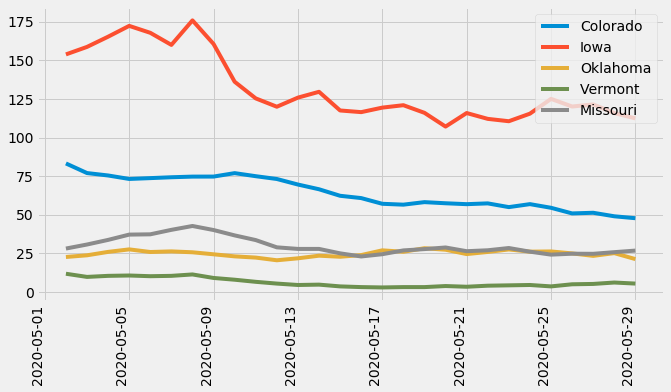

In [551]:
#Plots all states in training and test range - assumes all states have unique population densities
pop_densities = State_Compile.X['pop_density(t)'].unique()
state_df = State_Compile.X.copy()
state_df['Daily New Cases'] = State_Compile.y
i = 0

fig, axes = plt.subplots(figsize = (10, 6))
for pop_density in pop_densities:
    #Reset state_df every iteration
    state_df = State_Compile.X.copy()
    state_df['Daily New Cases'] = State_Compile.y
    
    #Choose state
    state_df = state_df[state_df['pop_density(t)'] == pop_density]
    x = state_df.loc[:, 'days_elapsed(t)']
    y = state_df.loc[:, 'Daily New Cases']
    axes.plot(x.apply(convert_to_date), y, label = State_Compile.state_list[i])
    axes.legend()
    i+= 1
    
fig.autofmt_xdate(rotation = 90)

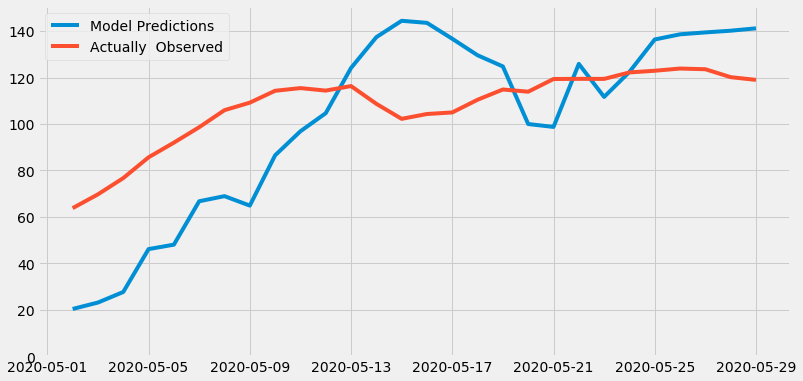

In [552]:
state_to_predict = 'Minnesota'

State_Analysis_X, State_Analysis_y = state_analysis(covid_df, state= state_to_predict, print_err = False)[1], state_analysis(covid_df, state= state_to_predict, print_err = False)[2]
fig, ax = plt.subplots(figsize = (12, 6))
ax.plot(State_Analysis_X['days_elapsed(t)'].apply(convert_to_date), State_Compile.rf.model.predict(State_Analysis_X), label = 'Model Predictions')
ax.plot(State_Analysis_X['days_elapsed(t)'].apply(convert_to_date), State_Analysis_y.values, label = 'Actually  Observed')
ax.set_ylim(0)
ax.legend()

In [553]:
#States maximum New Cases per pop over time interval
max_cases = covid_df.groupby('state').max()['New_Cases_per_pop']

#States new cases today
today_cases = covid_df[covid_df['days_elapsed'] == 104][['state', 'New_Cases_per_pop']].set_index('state').iloc[:, 0]

state_data = covid_df[['state', 'pop_density']]
state_data = state_data.drop_duplicates().set_index('state')
state_data['Decrease in case/pop'] = max_cases - today_cases
state_data.sort_values('Decrease in case/pop', ascending = False, inplace = True)
             
def plot_state(st, type = 'line', label = None):
    st_df = covid_df[covid_df['state'] == st]
    if type == 'line':
        plt.plot(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    else:
        plt.scatter(st_df['days_elapsed'], st_df['New_Cases_per_pop'], label = label)
    st_df = st_df.drop(['state', 'pop_density'], axis = 1)
    st_df.index.name = st
    return st_df

In [554]:
# State_Analysis_X['days_elapsed(t)'] = State_Analysis_X['days_elapsed(t)'] - 45

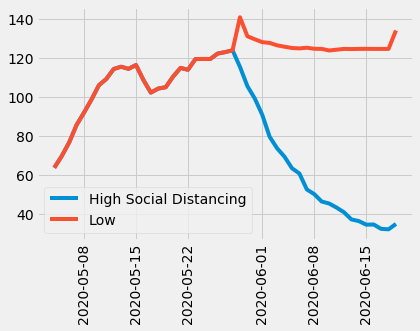

In [555]:
high_pred = generate_prediction_df(max_SD, State_Analysis_X, State_Analysis_y, predictions=21, rf = State_Compile.rf)
x = high_pred[0]['days_elapsed(t)']
y = high_pred[1]
plt.plot(x[-len(y):].apply(convert_to_date),y, label = 'High Social Distancing')
low_pred = generate_prediction_df([0.698571,0.972857,1.905714,0.504286, 0.608571, 1.144286, 0.980686], State_Analysis_X, State_Analysis_y, predictions=21, rf = State_Compile.rf)
x = low_pred[0]['days_elapsed(t)']
y = low_pred[1]
plt.plot(x[-len(y):].apply(convert_to_date),y, label ='Low')
plt.xticks(rotation = 90)

plt.legend()

In [25]:
test = low_pred[0].iloc[:47,:]
test['targ']= low_pred[1]

/Users/jbud/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


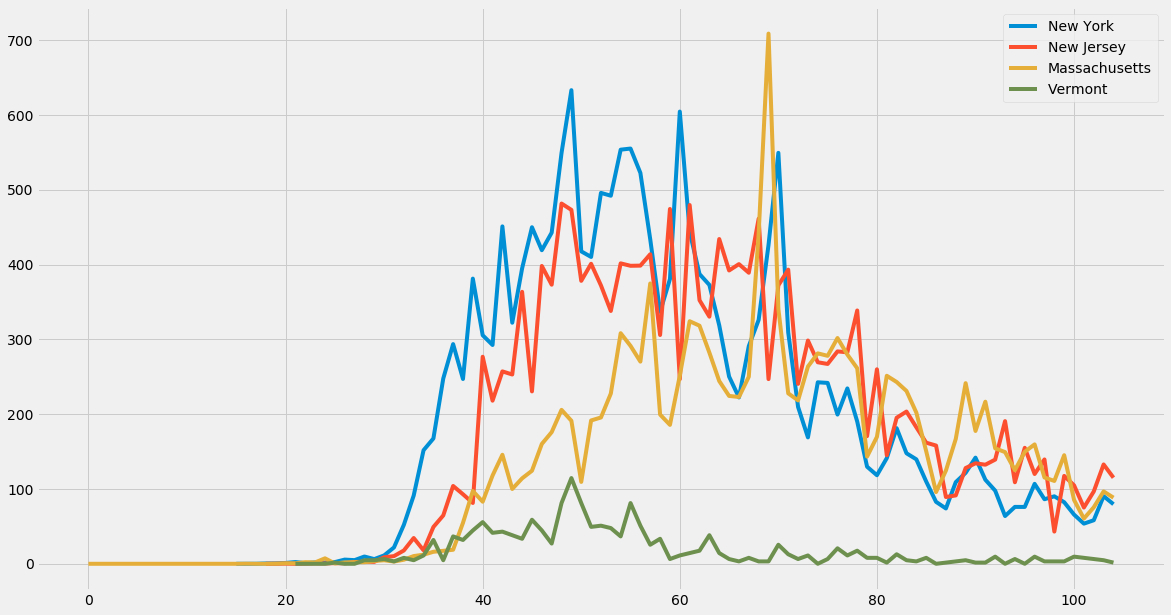

In [48]:
fig, axes = plt.subplots(figsize = (18, 10))
plt_type = 'line'
NY_df = plot_state('New York', type = plt_type, label = 'New York')
NJ_df = plot_state('New Jersey', type = plt_type, label = 'New Jersey')
MA_df = plot_state('Massachusetts', type = plt_type, label = 'Massachusetts')
VM_df = plot_state('Vermont', type = plt_type, label = 'Vermont')
plt.legend()

In [158]:
NY_df

,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,New_Cases_per_pop
New York,,,,,,,,,
2685,15,1.10,1.05,1.09,1.00,1.03,0.99,0.9934,0.000000
2686,16,1.06,1.05,1.16,0.99,1.04,1.00,1.0288,0.000000
2687,17,1.04,1.06,1.06,1.00,1.04,1.00,1.0594,0.051439
2688,18,1.07,1.08,1.16,1.00,1.03,1.00,1.0839,0.462952
2689,19,1.08,1.09,1.21,1.00,1.04,0.99,1.1334,0.565830
...,...,...,...,...,...,...,...,...,...
2770,100,0.51,0.85,1.70,0.33,0.27,1.23,0.7704,65.790594
2771,101,0.57,0.92,1.39,0.43,0.51,1.18,0.9024,53.702408
2772,102,0.59,0.95,1.40,0.44,0.52,1.19,0.9373,58.229048


In [98]:
len(State_Compile.X.columns)

30

In [101]:
y = State_Compile.rf.model.feature_importances_

([0, 1, 2, 3, 4, 5, 6, 7, 8], <a list of 9 Text xticklabel objects>)

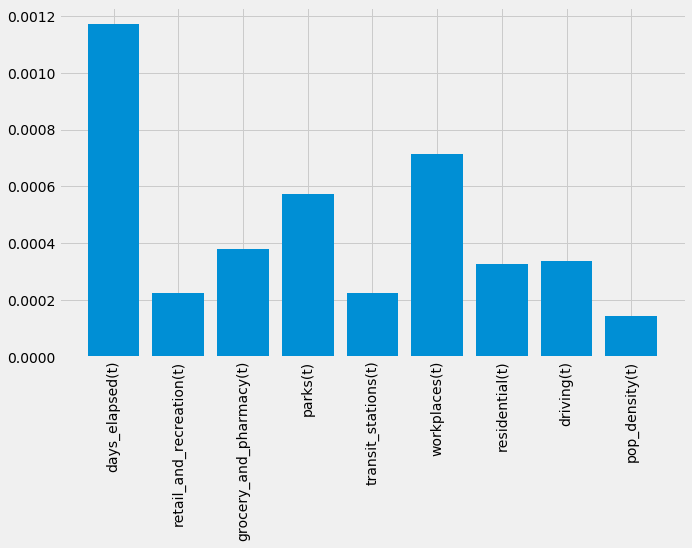

In [110]:
fig, axes = plt.subplots(figsize = (10, 6))
axes.bar(State_Compile.X.columns[-9:], y[-9:])
plt.xticks(rotation = 90)

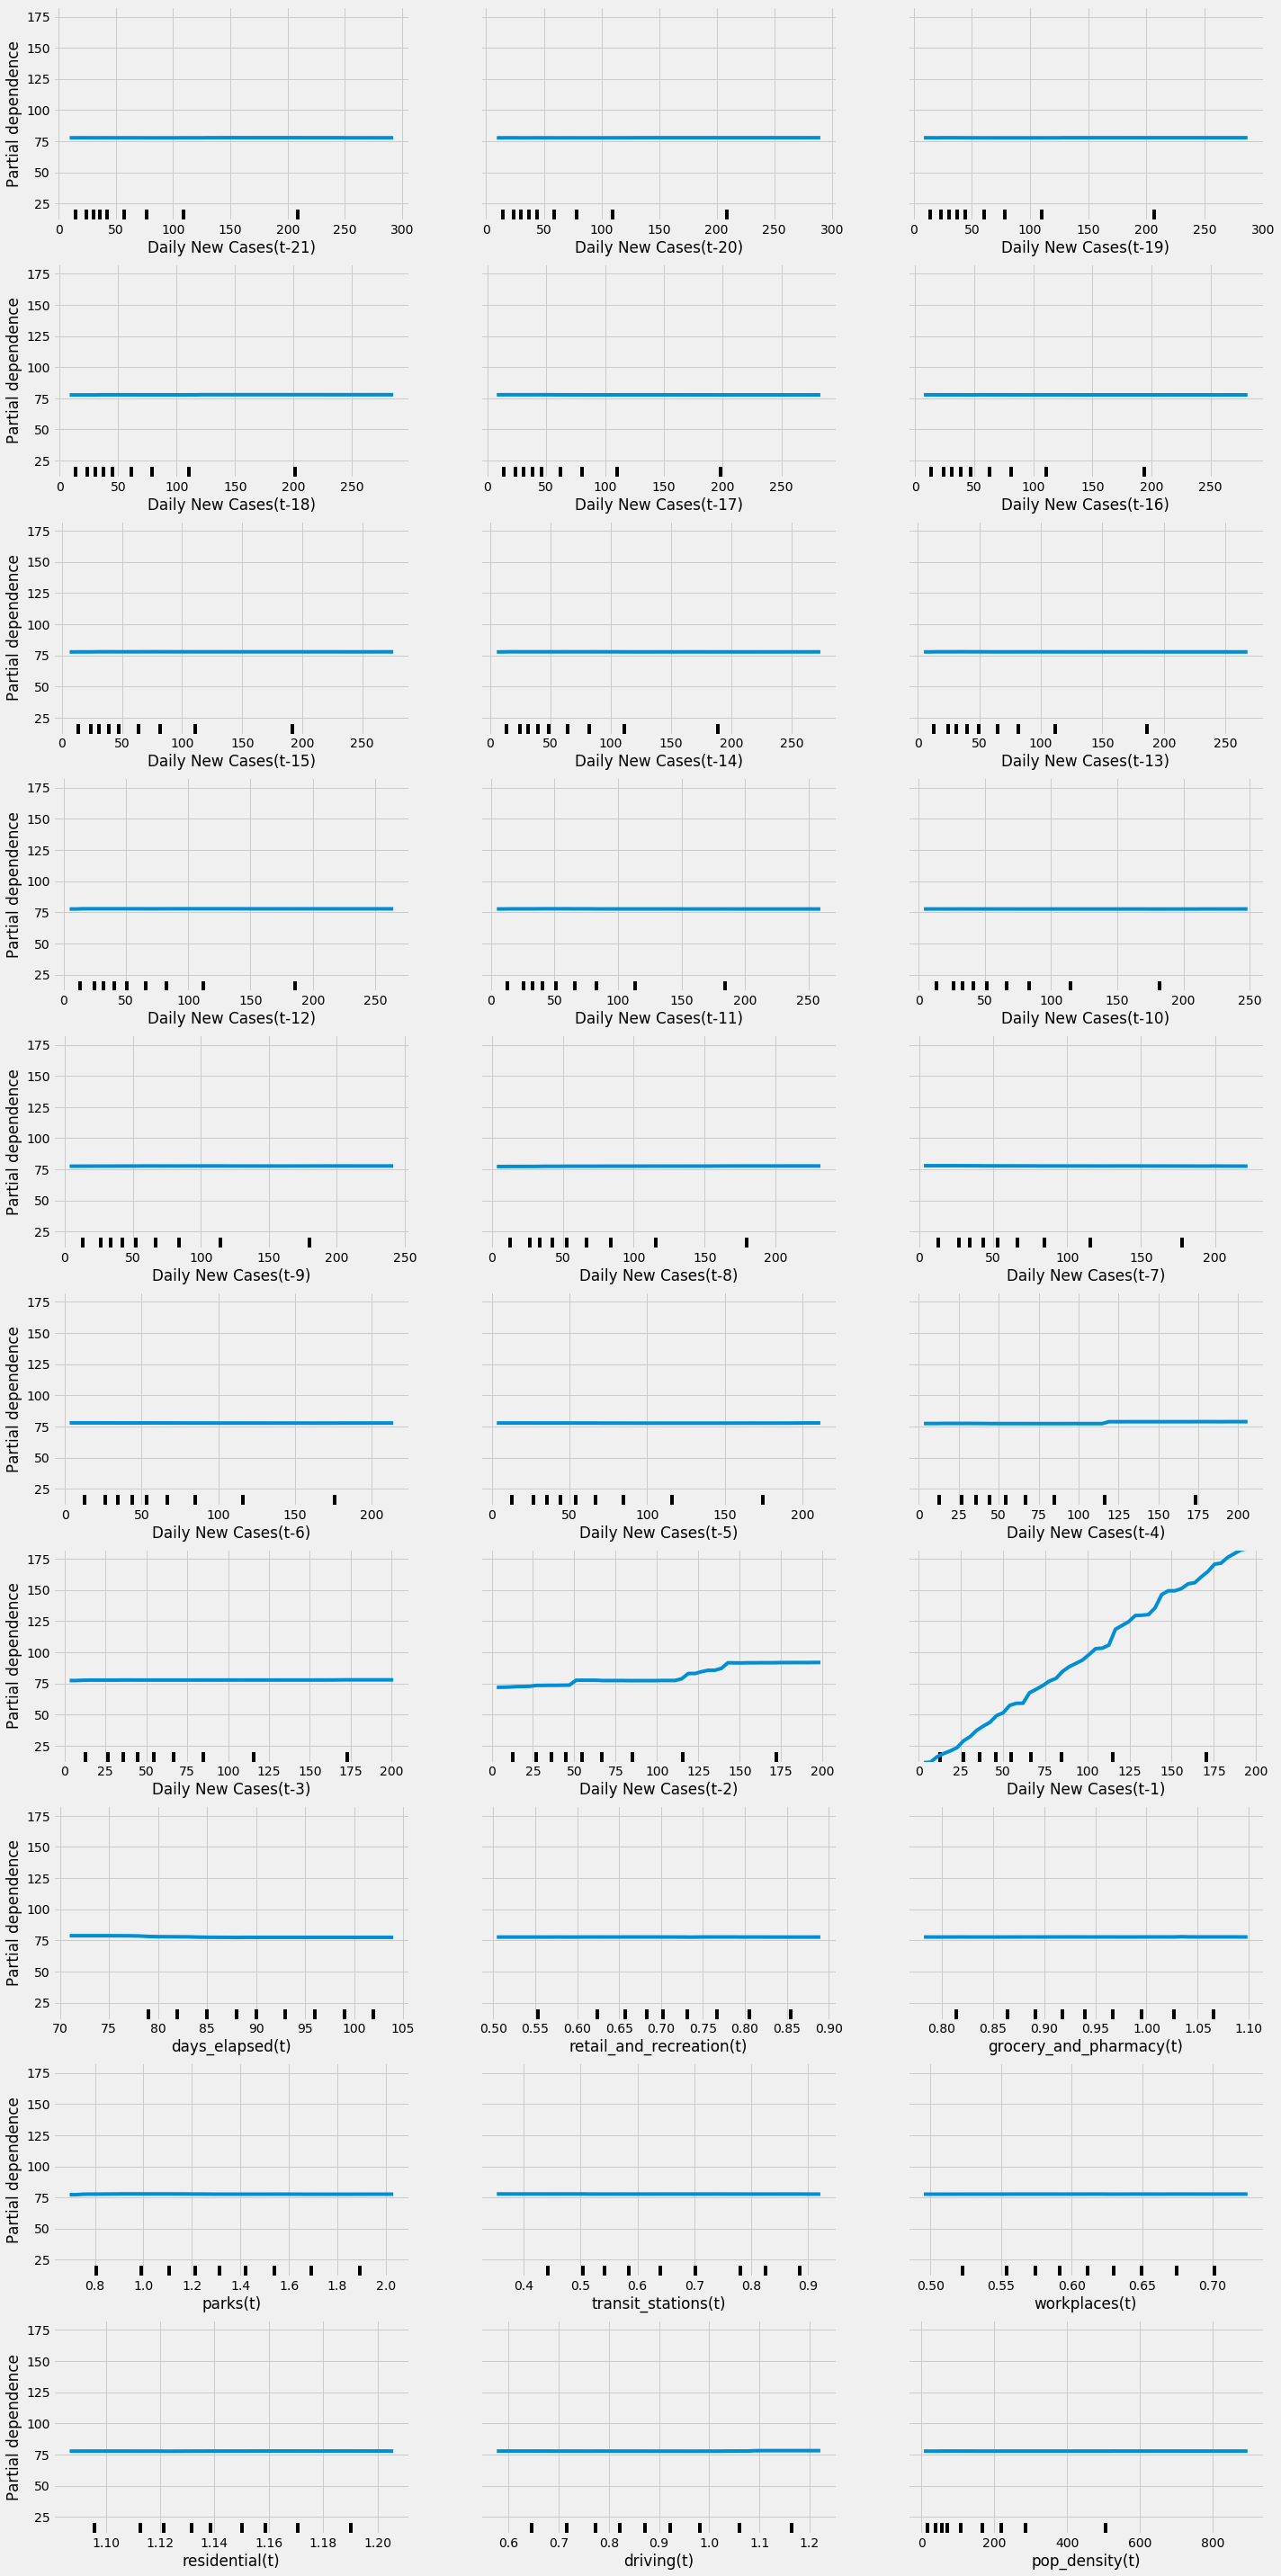

In [114]:
from sklearn.inspection import plot_partial_dependence
plot_partial_dependence(State_Compile.rf.model, State_Compile.X, State_Compile.X.columns, grid_resolution = 50)
fig = plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(40)
fig.tight_layout()

In [117]:
total = State_Compile.X.copy()

In [118]:
total['Daily New Cases'] = State_Compile.y

In [125]:
total.iloc[:,-10:]

,days_elapsed(t),retail_and_recreation(t),grocery_and_pharmacy(t),parks(t),transit_stations(t),workplaces(t),residential(t),driving(t),pop_density(t),Daily New Cases
21,77.0,0.711429,0.924286,1.054286,0.717143,0.632857,1.140000,0.820100,96.922125,36.903003
22,78.0,0.698571,0.910000,1.000000,0.708571,0.628571,1.145714,0.811129,96.922125,40.686434
23,79.0,0.702857,0.915714,1.004286,0.714286,0.630000,1.144286,0.825614,96.922125,42.694563
24,80.0,0.705714,0.918571,1.011429,0.718571,0.631429,1.144286,0.837043,96.922125,45.779514
25,81.0,0.727143,0.942857,1.095714,0.741429,0.640000,1.138571,0.864171,96.922125,49.097292
...,...,...,...,...,...,...,...,...,...,...
44,100.0,0.870000,1.080000,1.400000,1.038571,0.752857,1.082857,1.427650,5.840019,14.864550
45,101.0,0.878571,1.064286,1.465714,1.048571,0.757143,1.081429,1.427650,5.840019,19.399497
46,102.0,0.887143,1.050000,1.558571,1.064286,0.764286,1.078571,1.427650,5.840019,18.643673
47,103.0,0.907143,1.058571,1.684286,1.077143,0.767143,1.072857,1.427650,5.840019,18.391731


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a28573ef0>,
      dtype=object)

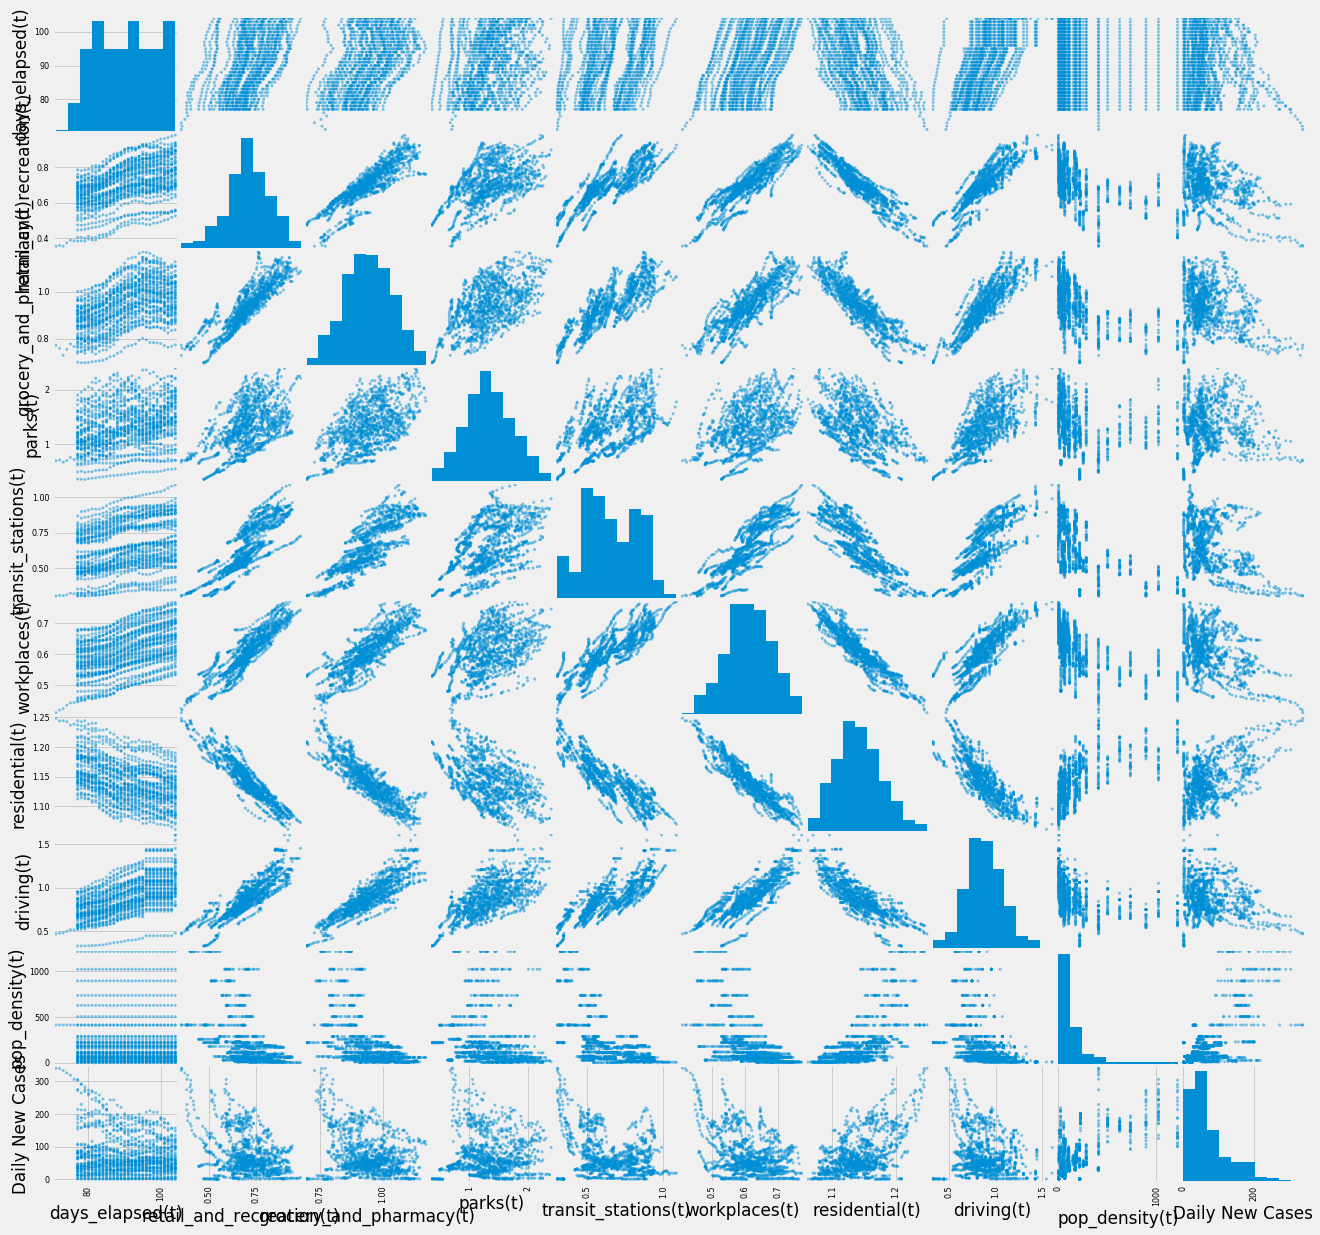

In [126]:
from pandas.plotting import scatter_matrix
scatter_matrix(total.iloc[:,-10:], figsize = (20,20))

In [164]:
MN_Analysis = other_state(state = 'Minnesota', per_capita = False)

In [165]:
MN_Analysis.df

,state,days_elapsed,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,driving,New_Cases
1913,Minnesota,20,1.060000,1.060000,1.060000,1.030000,0.990000,1.000000,1.306800,0.000000
1914,Minnesota,21,1.070000,1.090000,1.210000,1.070000,1.030000,0.990000,1.294500,0.000000
1915,Minnesota,22,1.130000,1.120000,1.930000,1.070000,1.020000,0.980000,0.942600,1.000000
1916,Minnesota,23,1.040000,1.030000,0.990000,0.950000,0.980000,1.010000,0.946700,0.000000
1917,Minnesota,24,1.060000,1.040000,1.060000,0.990000,0.980000,1.010000,0.990900,1.000000
...,...,...,...,...,...,...,...,...,...,...
1993,Minnesota,100,0.748571,1.025714,2.487143,0.534286,0.570000,1.132857,1.095771,706.142857
1994,Minnesota,101,0.744286,1.022857,2.368571,0.534286,0.570000,1.134286,1.095100,704.428571
1995,Minnesota,102,0.744286,1.021429,2.331429,0.534286,0.572857,1.134286,1.105186,685.000000
1996,Minnesota,103,0.742857,1.015714,2.352857,0.542857,0.577143,1.132857,1.128700,678.285714


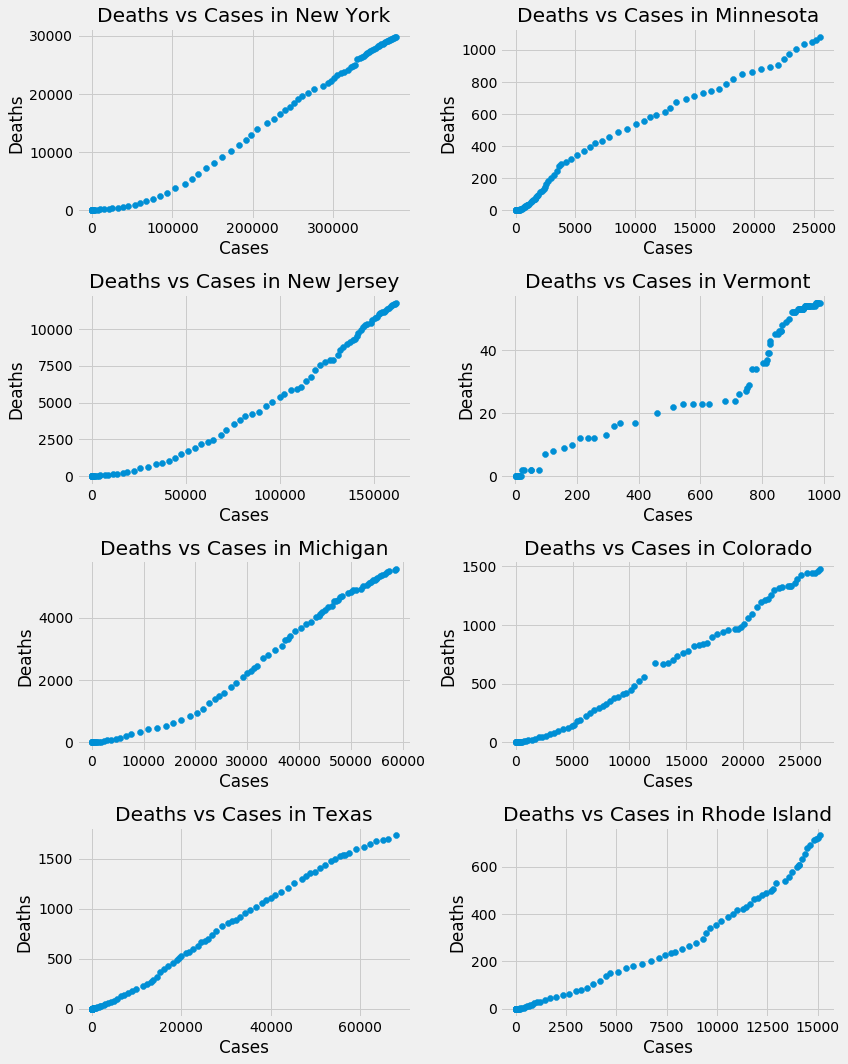

In [167]:
# Plot state deaths vs cases
def raw_state_data(states):
    covid_raw_df = pd.read_csv('data/covid-19-data/us-states.csv')
    state_raw_list = []
    for state in states:
        state_raw_list.append(covid_raw_df[covid_raw_df['state'] == state])
    return state_raw_list

fig, axes = plt.subplots(4, 2, figsize = (12,15))
state = ('New York', 'Minnesota', 'New Jersey', 'Vermont', 'Michigan', 'Colorado', 'Texas', 'Rhode Island')

state_list = raw_state_data(state)

for i, ax in enumerate(axes.flatten()):
    ax.scatter(state_list[i]['cases'], state_list[i]['deaths'])
    ax.set_title('Deaths vs Cases in {}'.format(state[i]))
    ax.set_xlabel('Cases')
    ax.set_ylabel('Deaths')
fig.tight_layout()
# Mostly linear trend between cases and deaths
fig.savefig('images/DeathVsCases')